# Exploration of confidence or certainty the predictions

In [2]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [48]:
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score

In [8]:
for scenario in ['multimodal_2023_regular', 'multimodal_2023_regular_ddld', 'multimodal_2023_extended', 'multimodal_2023_extended_ddld']:

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario =scenario, 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)
    
    data.df.to_csv('/home01/sam/notes_on_stats/doc/notebooks/{}.csv'.format(scenario), index=False)

377 administrations left.


id
diagnosis     
0.0        328
1.0         49

475 administrations left.


id
diagnosis     
0.0        328
1.0         49
2.0         98

388 administrations left.


id
diagnosis     
0.0        332
1.0         56

486 administrations left.


id
diagnosis     
0.0        332
1.0         56
2.0         98

In [5]:
pwd

'/home01/sam/notes_on_stats/doc/notebooks'

467 administrations left.


id
diagnosis     
0.0        417
1.0         50

Saving experiment in folder Final.
Doing experiment 13!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0  Weight sampling  0.867   0.523        0.916             0.233                  0.978                           0.646               0.156  0.646         0.299     0.842                                   0.471                                               0.78                                                       0.849                                            0.382                                              0.107                                  0.97                                    0.22                             0.618                             0.03  39  354  63  11

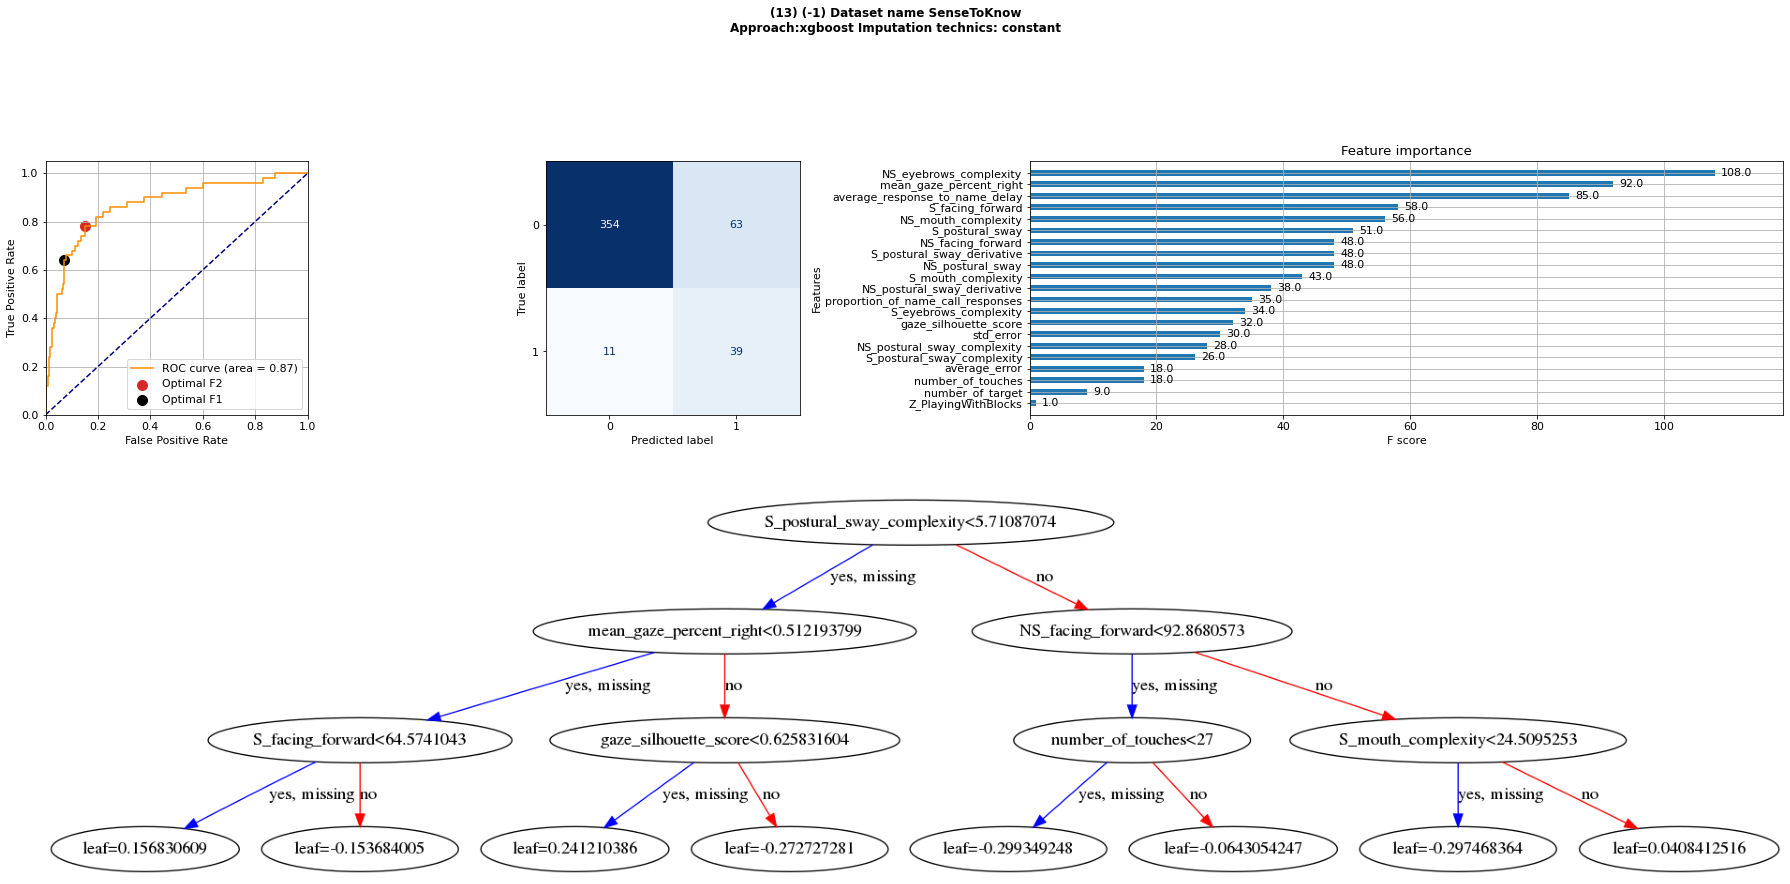

In [35]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='Final', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'Weight sampling',
                  verbosity=1, 
                  save_experiment=True)

exp.fit_predict(num_cv='loocv', sample_weight=weighted_confidence_score)
exp.plot()

# Computation of the shapley values acccounting for features missingness.

For each of the stored Shap values (i.e. the attribution of features importance on each sample), some might be associated to the contribution of the feature being missing, if for that sample the feature were actually missing.
In order to put things in order and disentangled to importance of the features values and their missingness, we here set to 0 the shapley value asociated to missing feature (HYP: the underlying hypothesis of doing that is that if a value is unknown, its contribution should be 0, and rather what should have this contrinution is the missingness of that variable).

*Notes*
- Given that the shap values was collected on each sample using cross-validation, i.e training a different model every time, we cannot compare or average the shap values directly. We first need to normalize each shap values $(\phi_k^i)_{k \in [1, K]}$ for $i \in [1, N]$. Since the sign is informative we still conserve it. 
- We verify that the features themselves have higher importance than their missingness.
- To compute the global importance of each of the features (when there are known, not when we miss them), we proceed as follows:
    1) First we only take into account the first half of the `general_shap_values_normalized` (features attribution when the values are know)

In [79]:
print("{} missing values".format((np.isnan(exp.dataset._X_train)).astype(int).sum()))

898 missing values


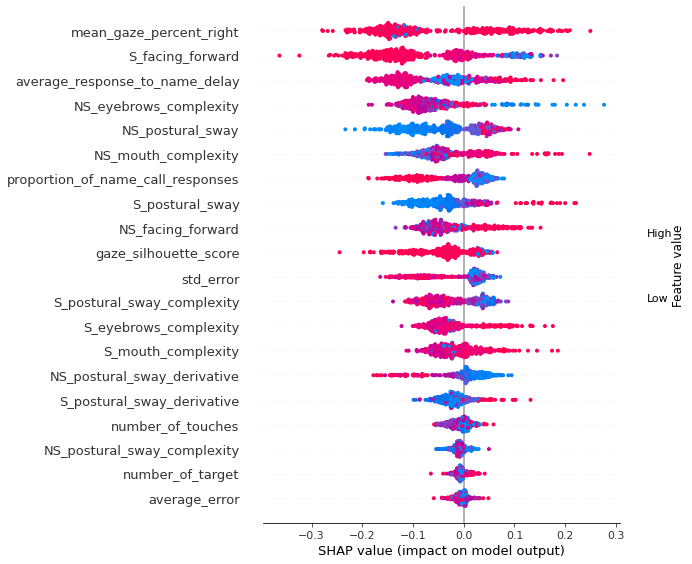

The average (std) contribution of the variables being missing are: 4.81% (+/- 12.09%)


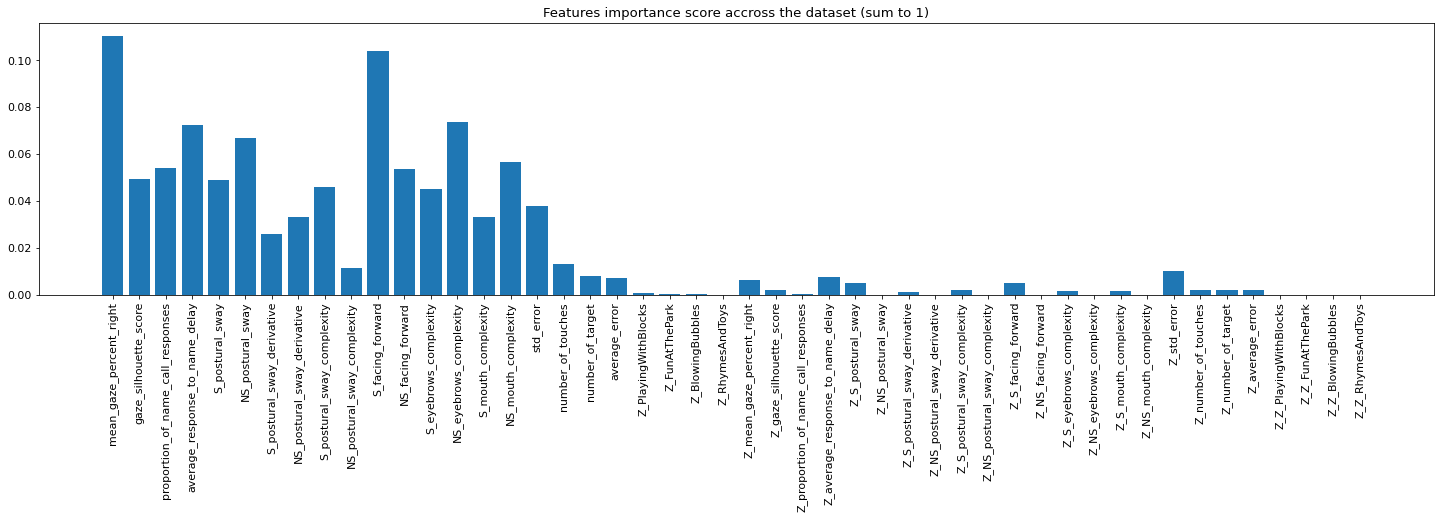

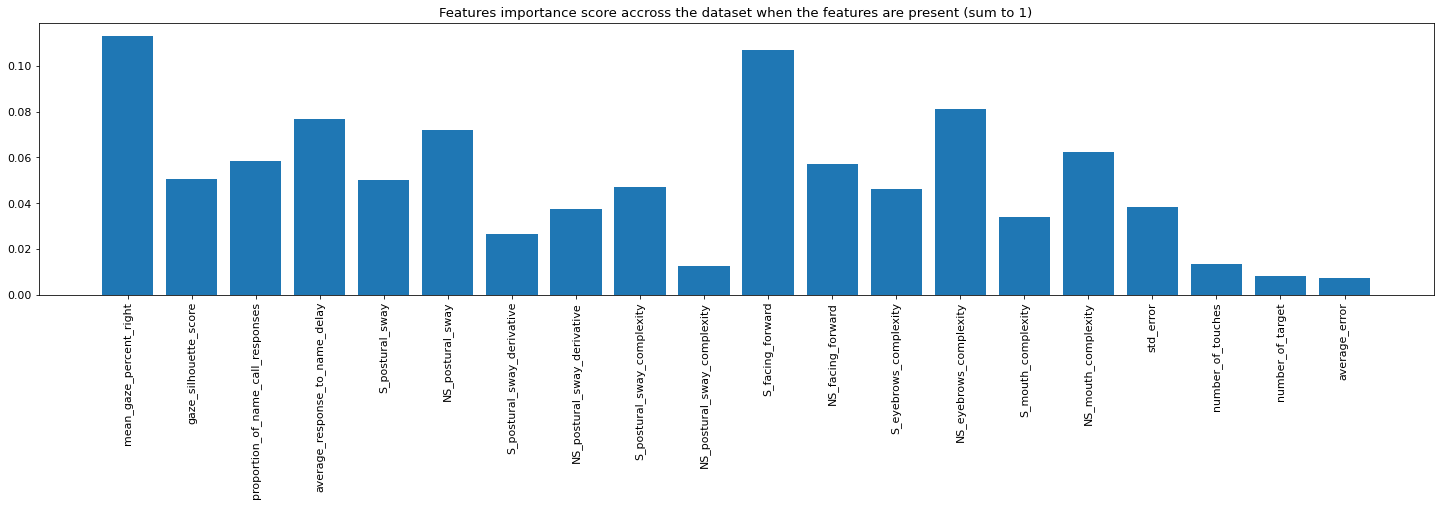

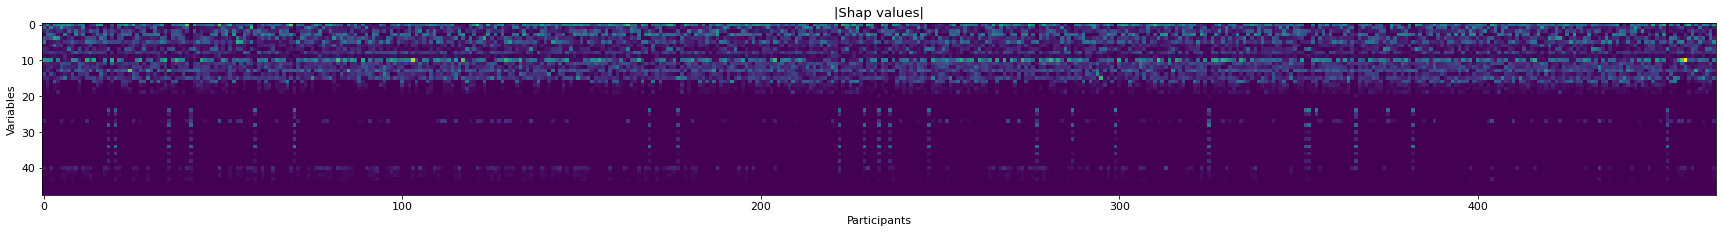

In [80]:
shap_values = np.zeros(exp.dataset.X_train.shape)

for i in range(exp.dataset.num_samples):
    shap_values[i, :] = exp.shap_values[i, i, :]
    
    
import shap
shap.summary_plot(shap_values, exp.dataset.X_train, feature_names = exp.features_name)# plot_type='bar')

mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values, mask_shap_present)
shap_missing = np.multiply(shap_values, (mask_shap_present==0).astype(int))


# Normalized shap value separating real variables and when there are missing.
general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
general_shap_values_normalized  = np.abs(general_shap_values) / np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
shap_attributions = np.abs(general_shap_values).sum(axis=0)/ np.abs(general_shap_values).sum()


labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]                  

fi(25, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(exp.features_name):
    plt.bar(i, shap_attributions[i], color='tab:blue')
plt.xticks(ticks = np.arange(len(exp.features_name)), labels=exp.features_name, rotation =90)

for i, feat in enumerate(exp.features_name):
    j = i + len(exp.features_name)
    plt.bar(j, shap_attributions[j], color='tab:blue')
plt.xticks(ticks = np.arange(shap_attributions.shape[0]), labels=labels, rotation =90)


shap_present_real_variables = shap_present[:, :20]
shap_present_normalized = np.abs(shap_present_real_variables) / np.abs(shap_present_real_variables).sum(axis=1)[:, np.newaxis] 
shap_attributions_present = np.abs(shap_present_normalized).sum(axis=0)/ np.abs(shap_present_normalized).sum()


for i, feat in enumerate(exp.features_name):
    j = i + len(exp.features_name)
    plt.bar(j, shap_attributions[j], color='tab:blue')
plt.xticks(ticks = np.arange(shap_attributions.shape[0]), labels=labels, rotation =90)

fi(25, 5)
plt.title("Features importance score accross the dataset when the features are present (sum to 1)")
for i, feat in enumerate(exp.features_name[:20]):
    plt.bar(i, shap_attributions_present[i], color='tab:blue')
plt.xticks(ticks = np.arange(len(exp.features_name[:20])), labels=exp.features_name[:20], rotation =90)

fi(30, 35)
plt.title("|Shap values|")
plt.imshow(general_shap_values_normalized.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

percent_missing_importance_mean = (1 - general_shap_values_normalized[:, :len(exp.features_name)].sum(axis=1)).mean()*100
percent_missing_importance_std =(1 - general_shap_values_normalized[:, :len(exp.features_name)].sum(axis=1)).std()*100

print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

# Building W the matrix of confidence in the different measure


In this section we aim at weighting the confidence we have in each of the input. The weight are between 0 and 1. This is an initial potentially naive way ay of weigthing the features confidences.
- For features that are an aggregation of the same feature over multiple videos, we use linear weighting (1 is all measures are available 0 otherwise, with linear mapping between these extremes).
- For the name call variables, we use the number of valid name call experiemnts. This can be 0, 1, 2, or 3. If 0 valid name call experiment, we set the weigths to 0. If there are at least one valid experiement, we still may or not ghave the information of the delay. In this case there are two scenraio that have been discussed. Either the participant answered and so the weighting is the same as the proportion of valid name call. If the participant did not answer, there is no "delay experiment", and so we set it to 0 (and not to the proportion...).
- For the touch variables, a measure of confidence we may have on the different variables could be proportional to the number of touches, with a maxmum confidence when the number of touches is higher than e.g. 15. 

For missing features, we let their weight to be 0, as we don't have the information of their value, but set to 1 the weight attributed to the indicator variable of its missingness (as xgboost handles missing data, it still uses the information of that feature being missing, so this information is accouted for).


There are two ways we can use these weights. 
1) During training and inference, we weight the input matrix by these weights, which influence the weighting of the gradient and hessian statiastics of the different optimization steps. 
2) More complex, using Bayesian ideas. We can see the input features as gaussians, with for instance a sigma parameter close to 0 if we have some certainty about the measure, and larger (value depends on the feature range etc), for input we are not to sure about.



<AxesSubplot:>

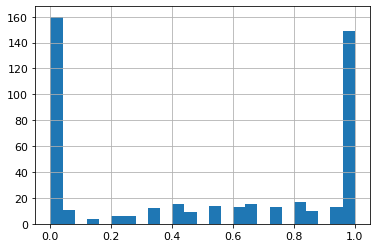

In [87]:
exp.dataset.df['touch_conf'].hist(bins=25)

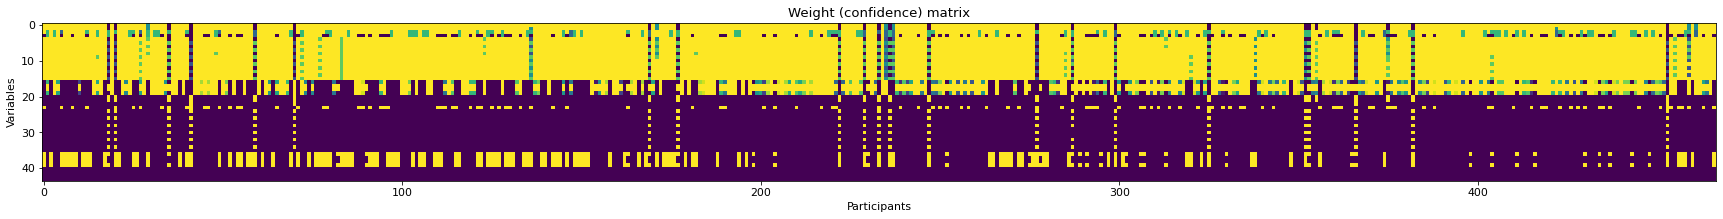

In [81]:
exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway']].isna()).sum(axis=1)/4
exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4
exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative']].isna()).sum(axis=1)/4
exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4
exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2

exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward']].isna()).sum(axis=1)/4
exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity']].isna()).sum(axis=1)/4
exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity']].isna()).sum(axis=1)/4
exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity']].isna()).sum(axis=1)/4
exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)


for conf_col in ['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf', 'NS_postural_sway_derivative_conf',
                 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 'proportion_of_name_call_responses_conf', 'average_response_to_name_delay_conf', 'touch_conf']:
    
    pass#exp.dataset.df.loc[exp.dataset.df[conf_col]==0, conf_col] = 1
    

conf_values = np.zeros((exp.dataset.num_samples, len(DEFAULT_PREDICTORS)))

for i, feat in enumerate(DEFAULT_PREDICTORS):
    
    if feat in TOUCH_VARIABLES:
        
        # These features don't depend on the number of touches, it is a value that we measures and so its confidence should be 1. 
        # We weight only the features that depend on the number of features.
        if feat in ['number_of_touches', 'number_of_target']:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int)
        
        else:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['touch_conf']
        
    elif feat == 'proportion_of_name_call_responses':
        
        conf_values[:, i] = exp.dataset.df['RTN_conf']
        
    elif feat == 'average_response_to_name_delay':
        
        # 0 if the delay is missing, the proportion of valid  name calls otherwise
        
        conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['RTN_conf']
            
    else:
        conf_values[:, i] = exp.dataset.df['{}_conf'.format(feat)]
        
    
    
# ----------------- Shanity check: show the values that are missing but don't have a confidence set to 0 (should not be the case) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere((mask_shap_present.astype(int)==0).astype(int) == 1):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if conf_values[coord[0]][coord[1]] != 0 :
        print(coord, conf_values[coord[0]][coord[1]], exp.dataset._X_train[coord[0]][coord[1]])
        
        
# ----------------- Shanity check: show the values that have a confidence of 0 but are not msising (should only be the case for the RTN delay if no valid NC) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere(conf_values==0):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if not np.isnan(exp.dataset._X_train[coord[0]][coord[1]]):
        if exp.features_name[coord[1]] != 'average_response_to_name_delay':
            print(coord, exp.dataset._X_train[coord[0]][coord[1]], exp.features_name[coord[1]])
            
            
            
# --------------- Add the weights asssociated with the missingness ---------------------- #
conf_values = np.concatenate([conf_values, np.isnan(exp.dataset._X_train).astype(int)], axis=1)

fi(30, 35)
plt.title("Weight (confidence) matrix")
plt.imshow(conf_values.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

In [108]:
# Experimental ...

#exp.dataset.df['Measures Confidence Uniform'] = exp.dataset.df[['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf',
#                                                        'NS_postural_sway_derivative_conf', 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 
 #                                                       'RTN_conf', 'touch_conf']].sum(axis=1)/8


#exp.dataset.df['Measures Confidence Weighted'] =  conf_values[:, :12].sum(axis=1)/12

# Computation of a quality score for each of the participants


Now that we computed the relative contribution of each features (and their missingness) for each participants, $G(X)$, and a confidence score associated in each of the variables, $W(X)$, we can compute a general confidence score on the prediction based on the initial information we had on each sample. 

The way to think about it seems to be: okay we had a certain distribution of confidence across the variables, they all have different importance to make the final prediction, what is the final confidence we have for a sample ? 


$$ Quality (X^i) = \sum_{k=0}^K G(X^i_k) W(X^i_k) $$




This quality has value between 0 and 1, with 1 when all features are available.general_shap_values_normalized

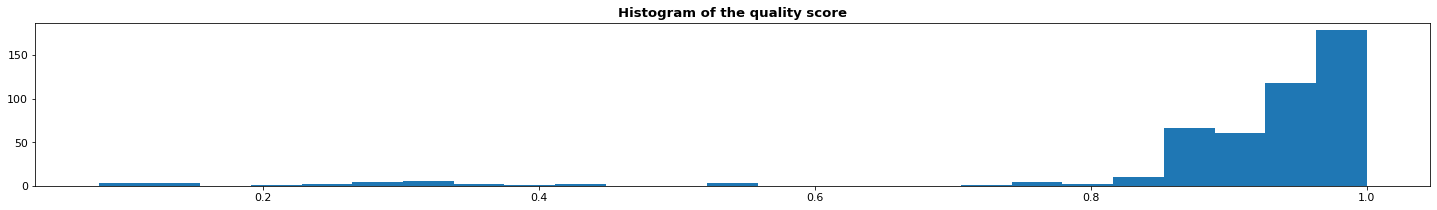

In [82]:
weighted_confidence_score = np.multiply(conf_values[:,:len(exp.features_name[:20])], shap_attributions_present).sum(axis=1)
np.save(os.path.join(DATA_DIR, 'weight_multimodal.npy'), weighted_confidence_score)

#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold')
plt.hist(weighted_confidence_score.flatten(), bins=25)
None

In [83]:
exp.predictions_df['conf'] = weighted_confidence_score

(0.0, 1.0)

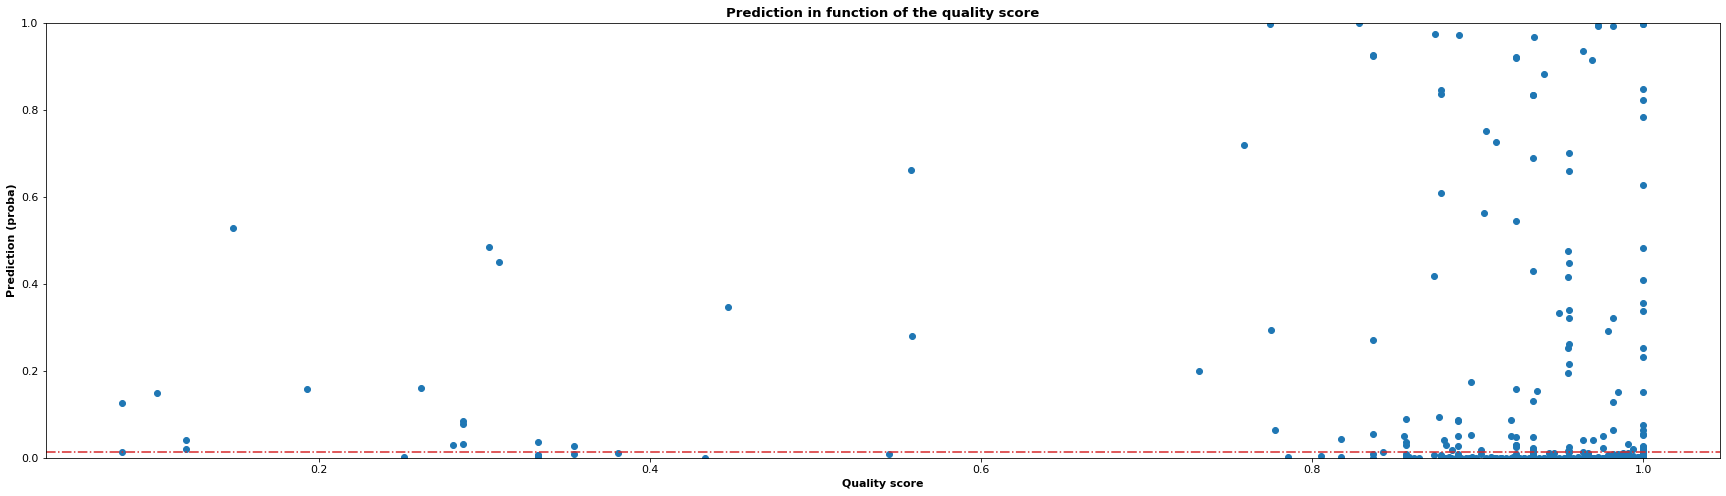

In [84]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']
fi(30, 8);ax=plt.gca()
plt.scatter(exp.predictions_df['conf'].to_numpy(), exp.predictions_df['y_pred'].to_numpy())
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.')
plt.title("Prediction in function of the quality score", weight='bold')
plt.xlabel("Quality score", weight='bold');plt.ylabel("Prediction (proba)", weight='bold')

plt.ylim([0, 1])

(0.0, 1.0)

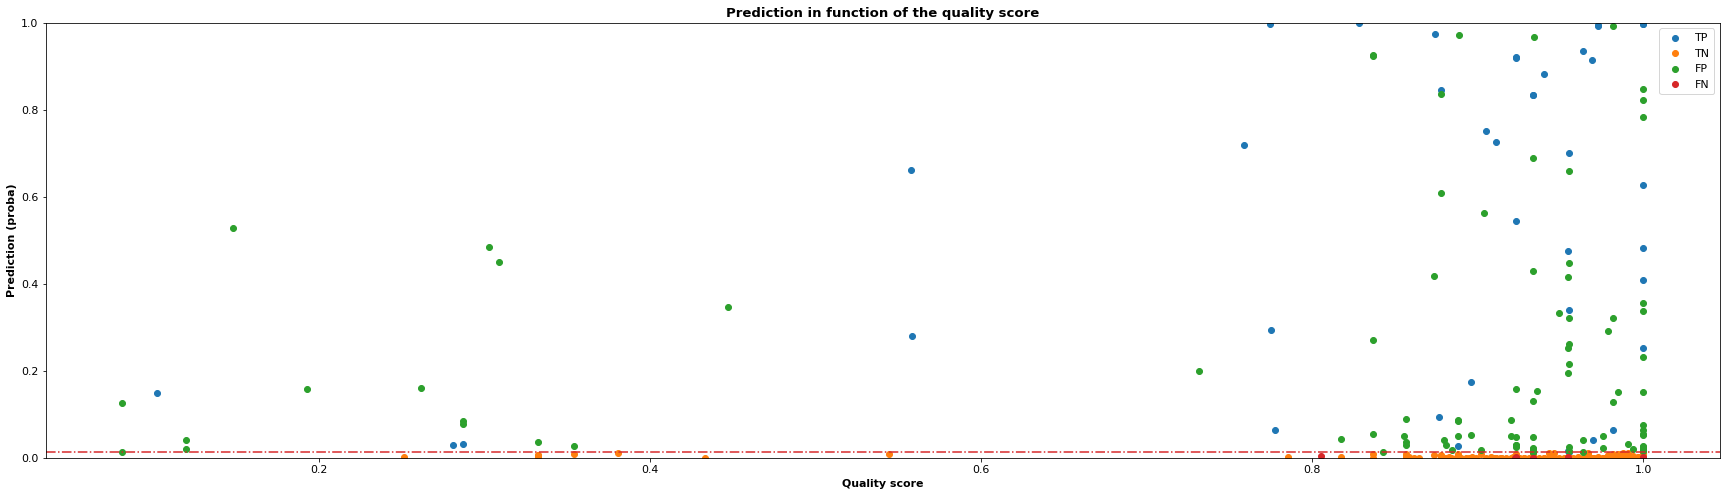

In [85]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']

fi(30, 8);ax=plt.gca()
for name in names:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['conf'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()
plt.title("Prediction in function of the quality score", weight='bold')
plt.xlabel("Quality score", weight='bold');plt.ylabel("Prediction (proba)", weight='bold')
plt.ylim([0, 1])


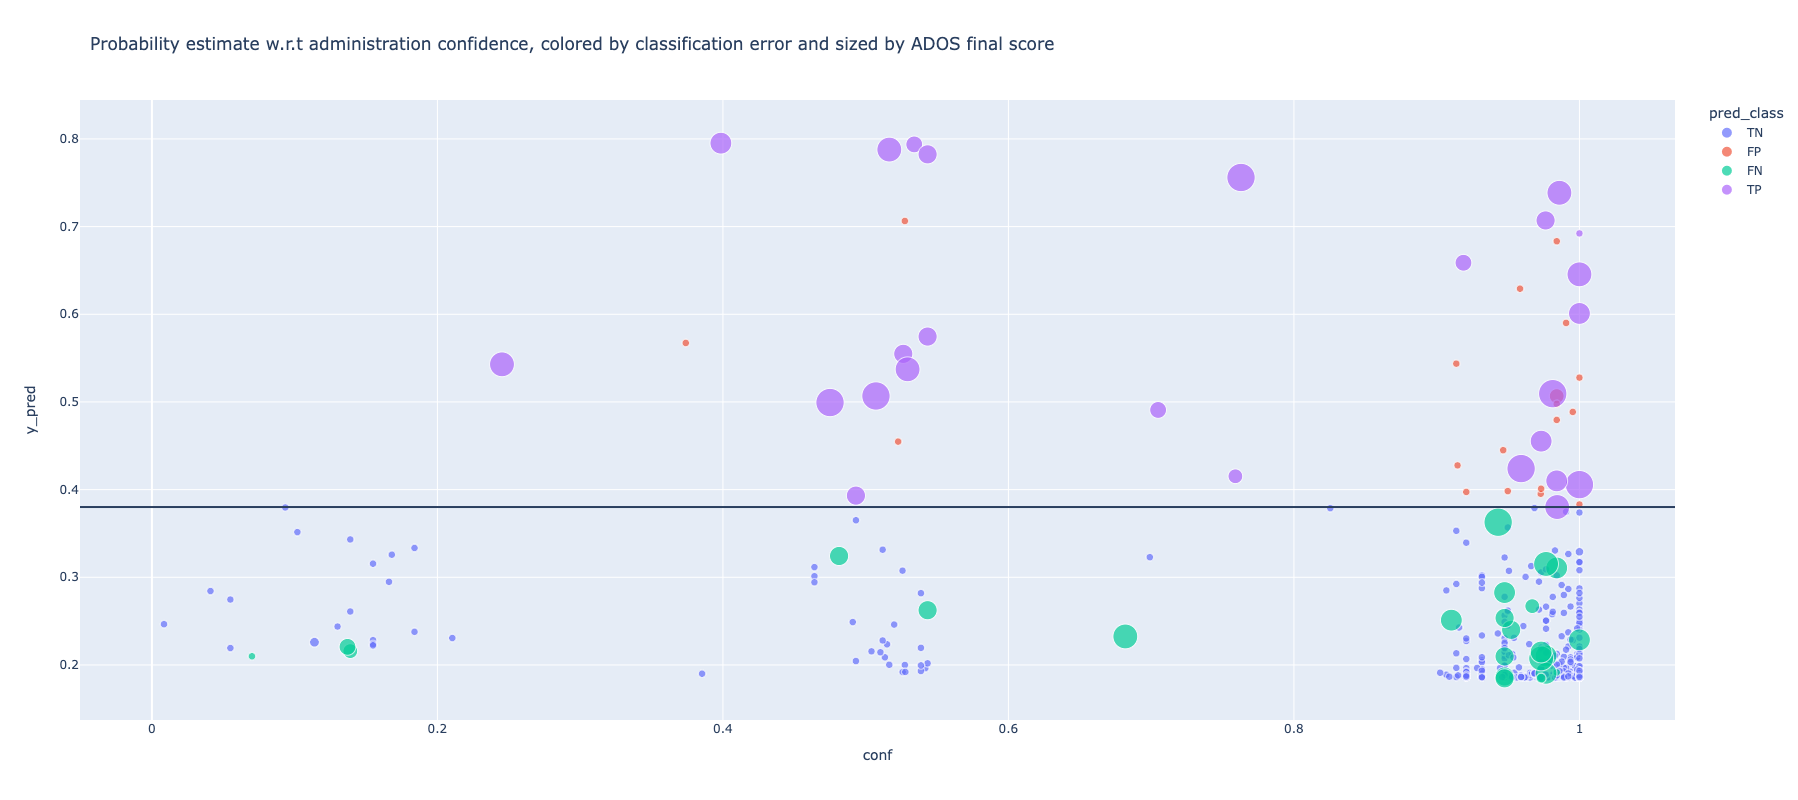

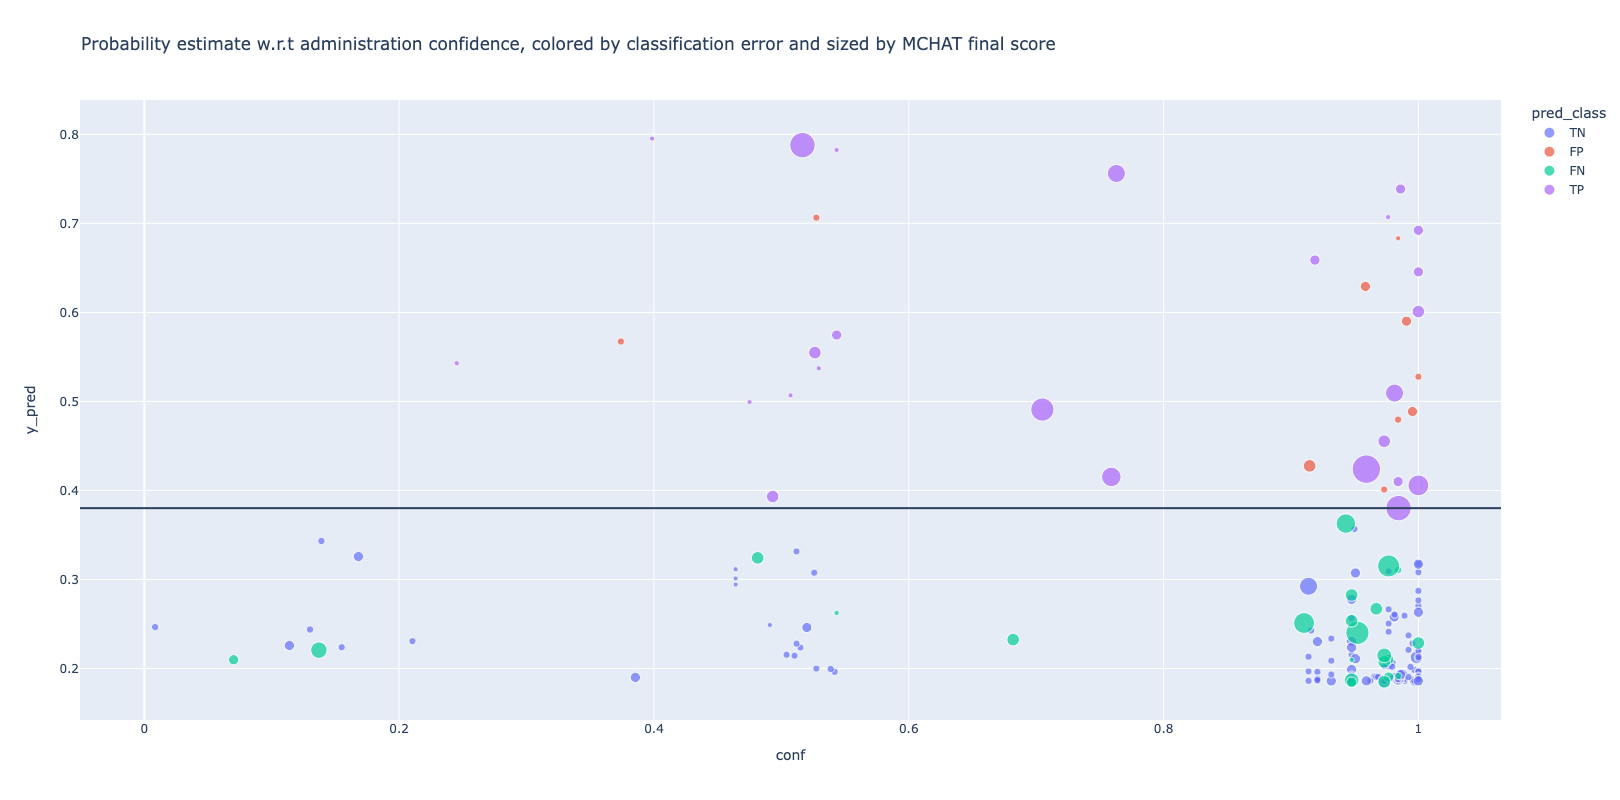

In [182]:
import plotly.express as px
df_to_plot = pd.DataFrame({'conf': exp.predictions_df['conf'].to_numpy(),
                           'y_pred': exp.predictions_df['y_pred'].to_numpy(),
                           'pred_class': exp.predictions_df['pred_class'].to_numpy(),
                           'diagnosis': exp.dataset.df['diagnosis'].to_numpy(),
                           'ados_total': exp.dataset.df['ados_total'].replace({np.nan: -1}).to_numpy(),
                           'ados_total_size': exp.dataset.df['ados_total'].apply(lambda x: 1 if np.isnan(x) else 1.3**x).to_numpy(),
                           'mchat_final': exp.dataset.df['mchat_final'].replace({np.nan: 0.5}).to_numpy(),
                           'mchat_final_size': exp.dataset.df['mchat_final'].apply(lambda x: .5 if np.isnan(x) else 1.2**x).to_numpy(),
                           # This is a proxy for whether there were strong effects among the features of that participants, or sailance
                           'norm_asbsolute_shap_values': np.abs(general_shap_values).sum(axis=1), 
                           # This is a proxy for the maximum saillant behavior
                           'max_relative_effect': (np.abs(general_shap_values) / (1e-10 + np.abs(general_shap_values).max(axis=0))).max(axis=1),
                           'id': exp.dataset.df['id'].to_numpy(),
                           'pred_class': exp.predictions_df['pred_class'].to_numpy(),
                           'size': np.ones(467)*1,
                           
                          }).round(5)

fig = px.scatter(df_to_plot, x="conf", y="y_pred", log_x=False, color='pred_class', size='ados_total_size',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'], 
                 title="Probability estimate w.r.t administration confidence, colored by classification error and sized by ADOS final score", width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()

fig = px.scatter(df_to_plot, x="conf", y="y_pred", log_x=False, color='pred_class', size='mchat_final',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'], 
                 title="Probability estimate w.r.t administration confidence, colored by classification error and sized by MCHAT final score", width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()


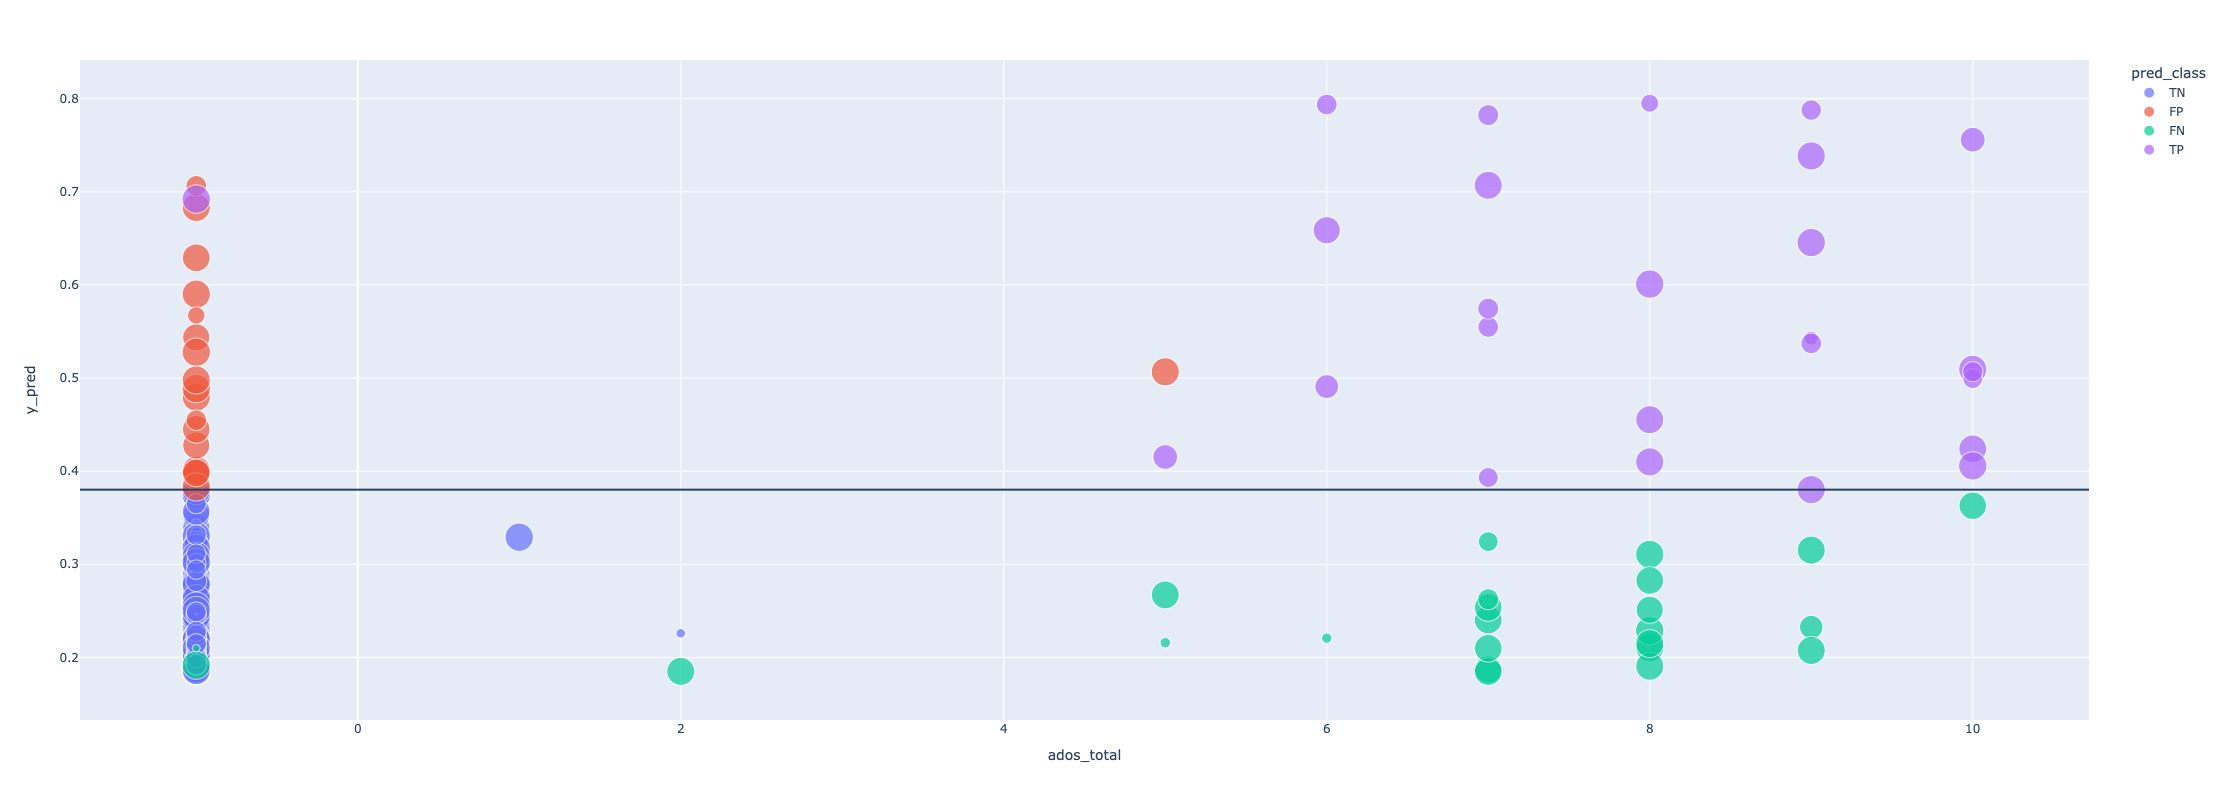

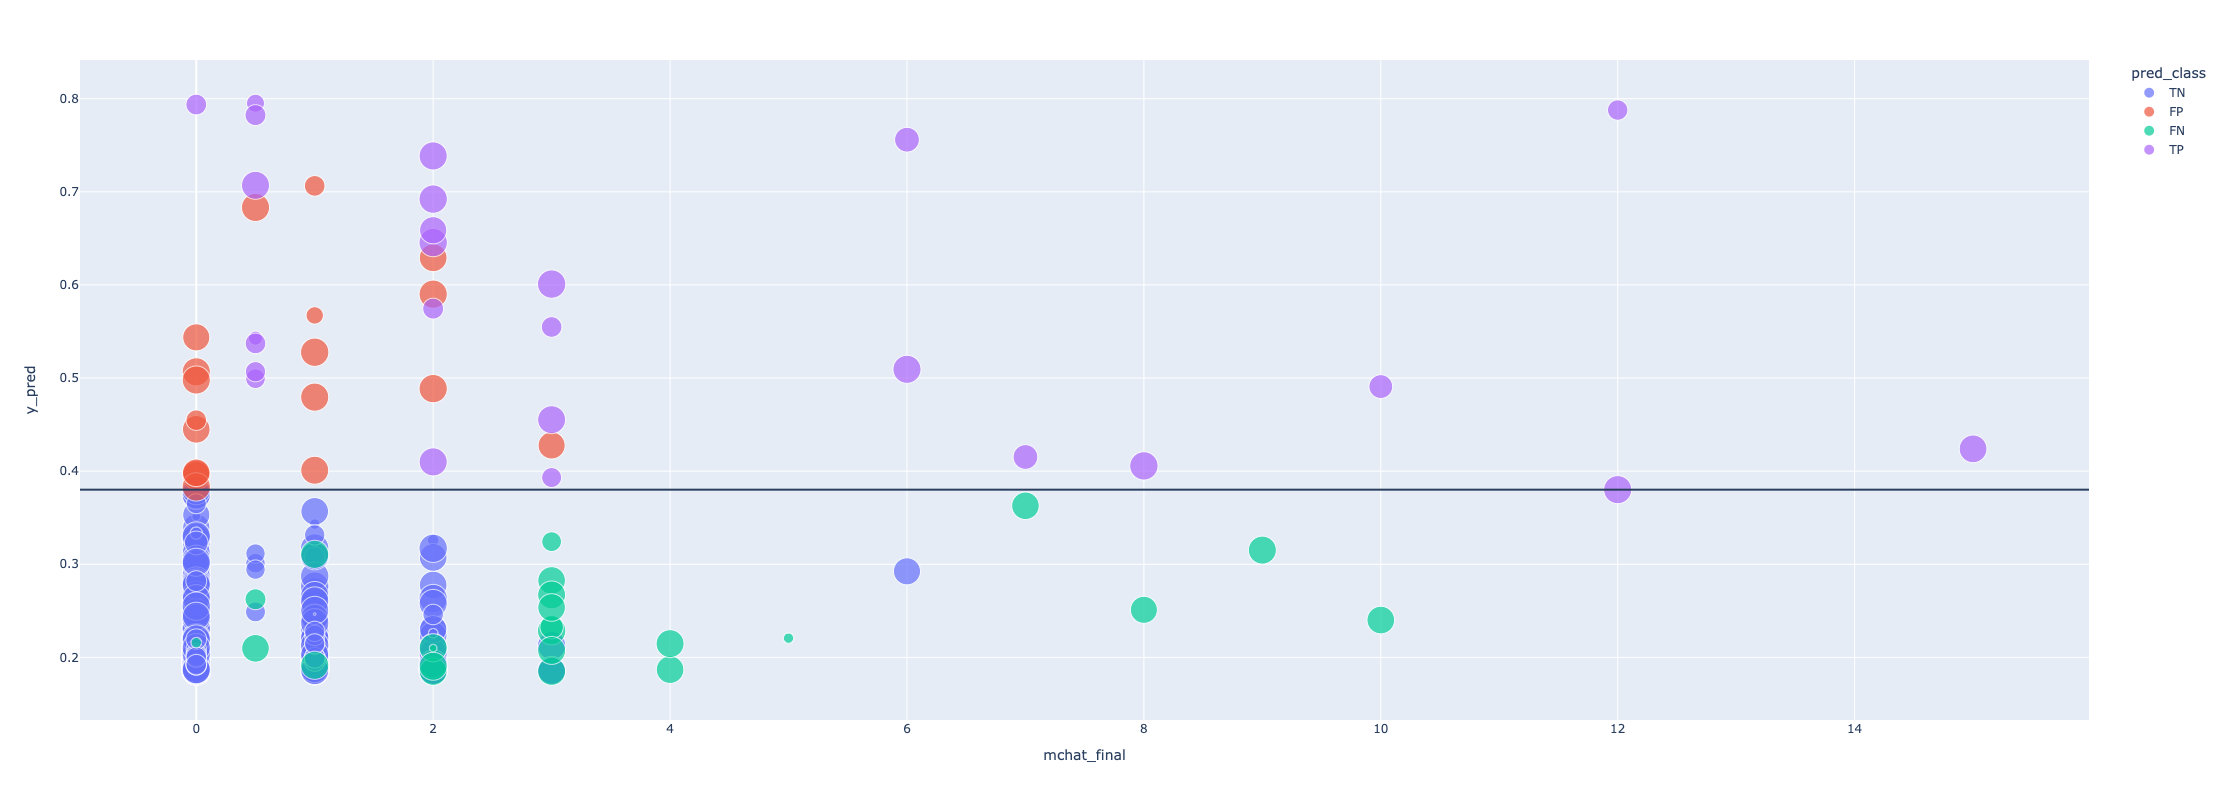

In [183]:
fig = px.scatter(df_to_plot, x="ados_total", y="y_pred", log_x=False, color='pred_class', size='conf',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'],
                 width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()

fig = px.scatter(df_to_plot, x="mchat_final", y="y_pred", log_x=False, color='pred_class', size='conf',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'], 
                 width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()


# Measure of uncertainty from non-saillant behaviors 

In [184]:
exp.predictions_df['norm_asbsolute_shap_values'] =  (np.abs(general_shap_values)**2).sum(axis=1)
# This is a proxy for the maximum saillant behavior
exp.predictions_df['max_shap_value'] =  np.abs(general_shap_values)[:, :12].max(axis=1)# (np.abs(general_shap_values) / (1e-10 + np.abs(general_shap_values).max(axis=0))).max(axis=1)

Text(0, 0.5, 'Prediction (Proba)')

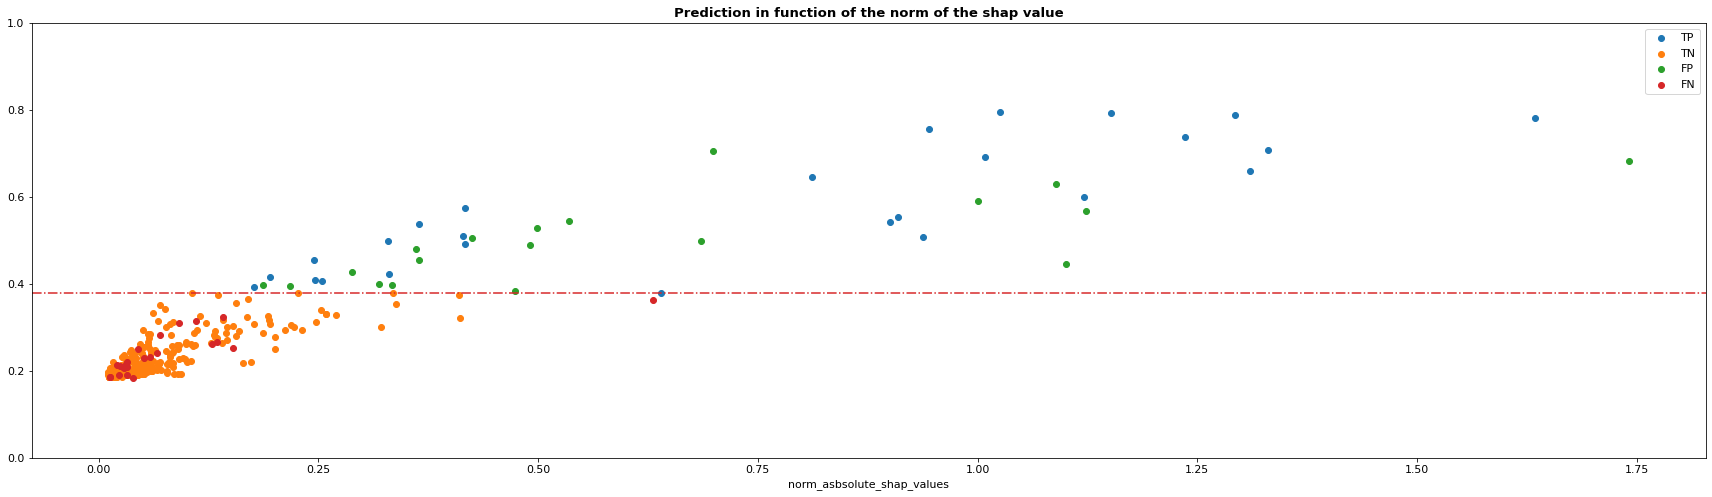

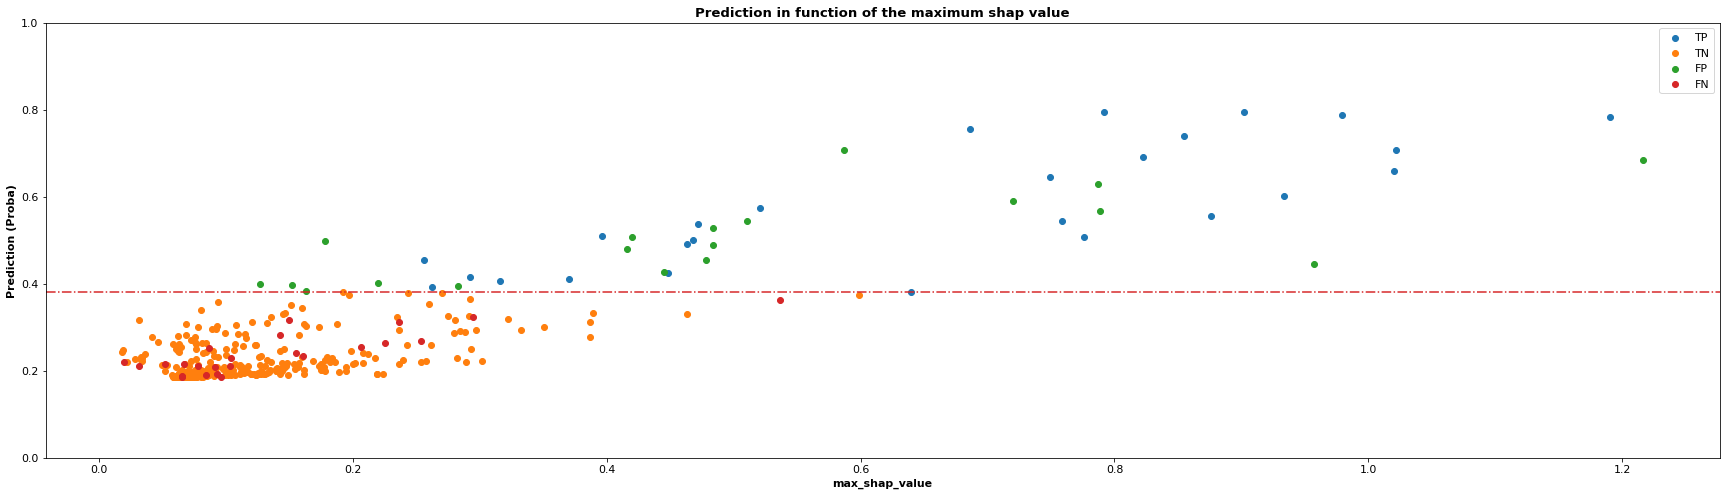

In [185]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']

fi(30, 8);ax=plt.gca()
for name in names:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['norm_asbsolute_shap_values'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()
plt.title("Prediction in function of the norm of the shap value", weight='bold')
plt.ylim([0, 1]);plt.xlabel('norm_asbsolute_shap_values')

fi(30, 8);ax=plt.gca()
for name in names:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['max_shap_value'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()
plt.title("Prediction in function of the maximum shap value", weight='bold')
plt.ylim([0, 1]);plt.xlabel('max_shap_value', weight='bold'); plt.ylabel('Prediction (Proba)', weight='bold')

In [ ]:
# Ajouter a la taille des points la severite  autistique 

# Parler de la zone du milieu 


# Non linearite sur le mapping de W: mieux d'avoir 1 que 0 ou 5 que 4 ? 


# THEO proche de la moyenne a cause de comportement potentiellementx extremes mais sur des features mal notees (peu de conf)
# SOlution: utiliser la confiance en les features au moment de la prediction. Calculer des probas corriger OU PAS! Pck l'importance de cette feature elle est clair et fixe, et meme si on a 25 de confiance begh tant pis
# Classer les individus pas la somme des valeurs absolus des shap 

# Proba myene peut etre deux features aux deux extremes 
# ID: predre la norme des hsap values ... ? 






In [108]:
# We need for the feature that are missing but still have an importance (due to xgboost handling MD) to account for those by leveraging the Z !

(array([ 79., 103.,  19.,  21.,  24.,  29.,  24.,  16.,  14.,  17.,  18.,
         11.,   8.,   6.,  10.,   1.,   4.,   5.,   5.,   6.,   3.,   6.,
          2.,   1.,   1.,   2.,   2.,   3.,   1.,   3.,   1.,   2.,   2.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   3.,   1.,   1.,   4.,
          1.,   1.,   0.,   1.,   3.,   1.]),
 array([0.32612959, 0.3721671 , 0.4182046 , 0.46424211, 0.51027961,
        0.55631712, 0.60235462, 0.64839213, 0.69442963, 0.74046713,
        0.78650464, 0.83254214, 0.87857965, 0.92461715, 0.97065466,
        1.01669216, 1.06272967, 1.10876717, 1.15480468, 1.20084218,
        1.24687969, 1.29291719, 1.3389547 , 1.3849922 , 1.43102971,
        1.47706721, 1.52310472, 1.56914222, 1.61517973, 1.66121723,
        1.70725474, 1.75329224, 1.79932974, 1.84536725, 1.89140475,
        1.93744226, 1.98347976, 2.02951727, 2.07555477, 2.12159228,
        2.16762978, 2.21366729, 2.25970479, 2.3057423 , 2.3517798 ,
        2.39781731, 2.44385481, 2.48989232, 2.

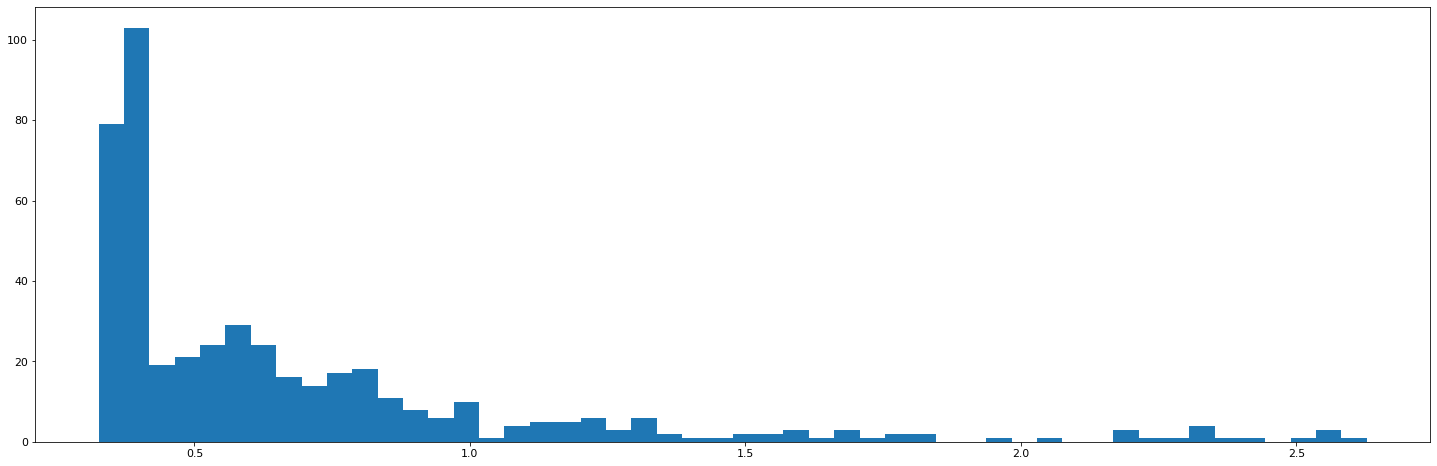

In [186]:
fi(25, 8)
plt.hist(np.abs(general_shap_values).sum(axis=1), bins=50)

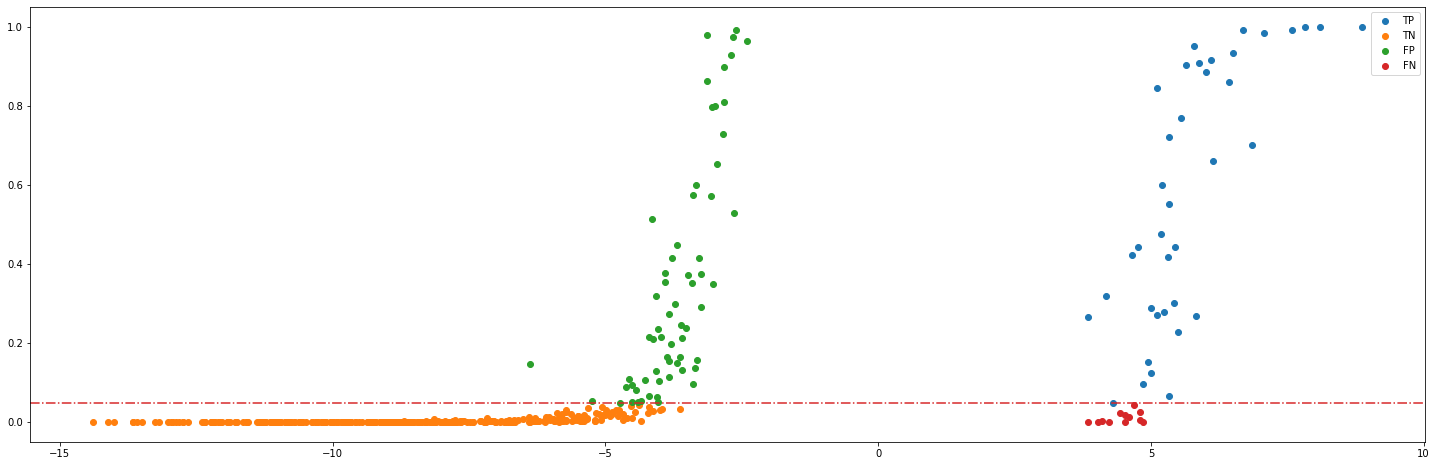

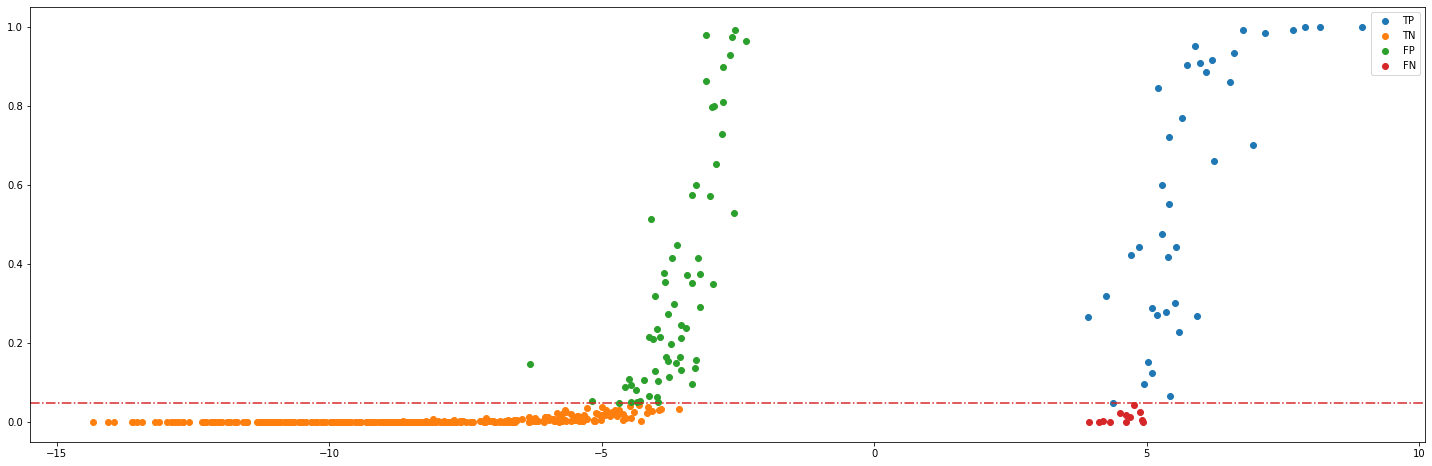

In [24]:
import shap

explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)
models_expected_value = explainer.expected_value

exp.predictions_df['f_x'] = np.nan
exp.predictions_df['f_x_all'] = np.nan


for idx in range(exp.dataset.num_samples):
    exp.predictions_df.loc[idx, 'f_x'] = shap_values[idx].sum() +  exp.models_expected_value[idx]
    exp.predictions_df.loc[idx, 'f_x_all'] = explainer.shap_values(exp.dataset.X_train)[idx].sum() +  explainer.expected_value
    
exp.predictions_df['y_pred_all'] = 1/(1 + np.exp(-exp.predictions_df['f_x'].to_numpy()))
    
exp.predictions_df.sort_values(by='f_x')[['y_pred', 'y_true','f_x', 'TP', 'TN', 'FP', 'FN']]#[:30]

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x_all'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

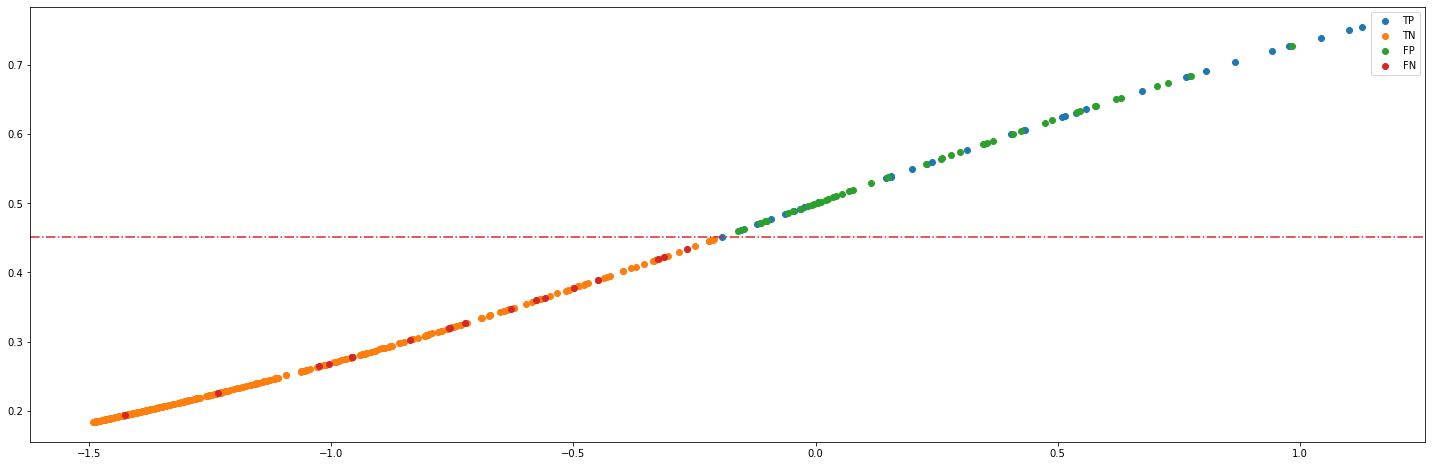

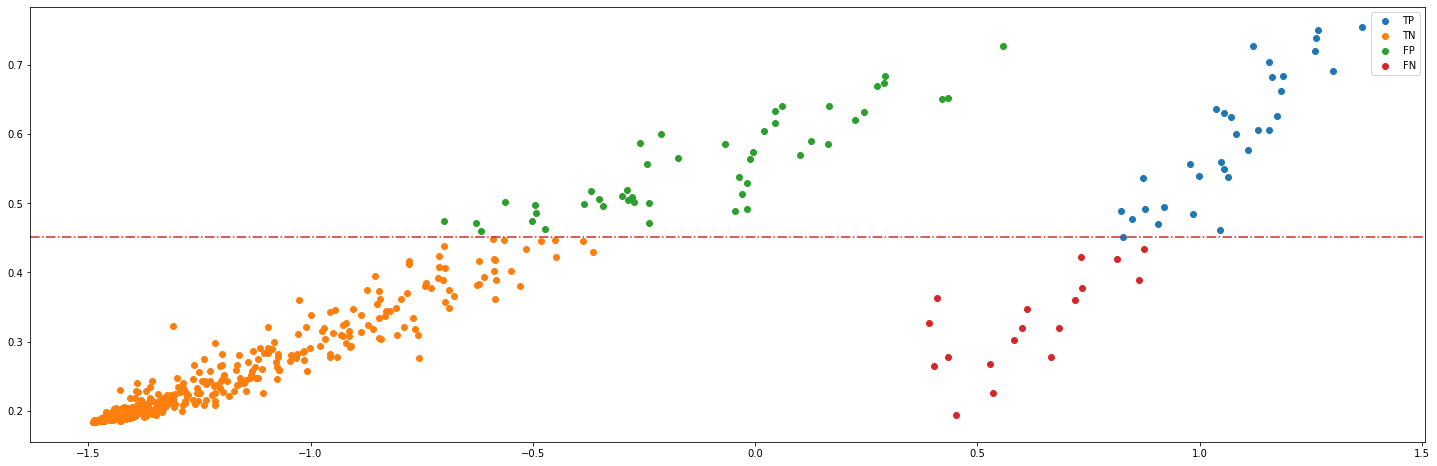

In [47]:
import shap

explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)
models_expected_value = explainer.expected_value

exp.predictions_df['f_x'] = np.nan
exp.predictions_df['f_x_all'] = np.nan


for idx in range(exp.dataset.num_samples):
    exp.predictions_df.loc[idx, 'f_x'] = shap_values[idx].sum() +  exp.models_expected_value[idx]
    exp.predictions_df.loc[idx, 'f_x_all'] = explainer.shap_values(exp.dataset.X_train)[idx].sum() +  explainer.expected_value
    
exp.predictions_df['y_pred_all'] = 1/(1 + np.exp(-exp.predictions_df['f_x'].to_numpy()))
    
exp.predictions_df.sort_values(by='f_x')[['y_pred', 'y_true','f_x', 'TP', 'TN', 'FP', 'FN']]#[:30]

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x_all'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

In [63]:
exp.predictions_df['y_pred_all'] = 1/(1 + np.exp(-exp.predictions_df['f_x_all'].to_numpy()))

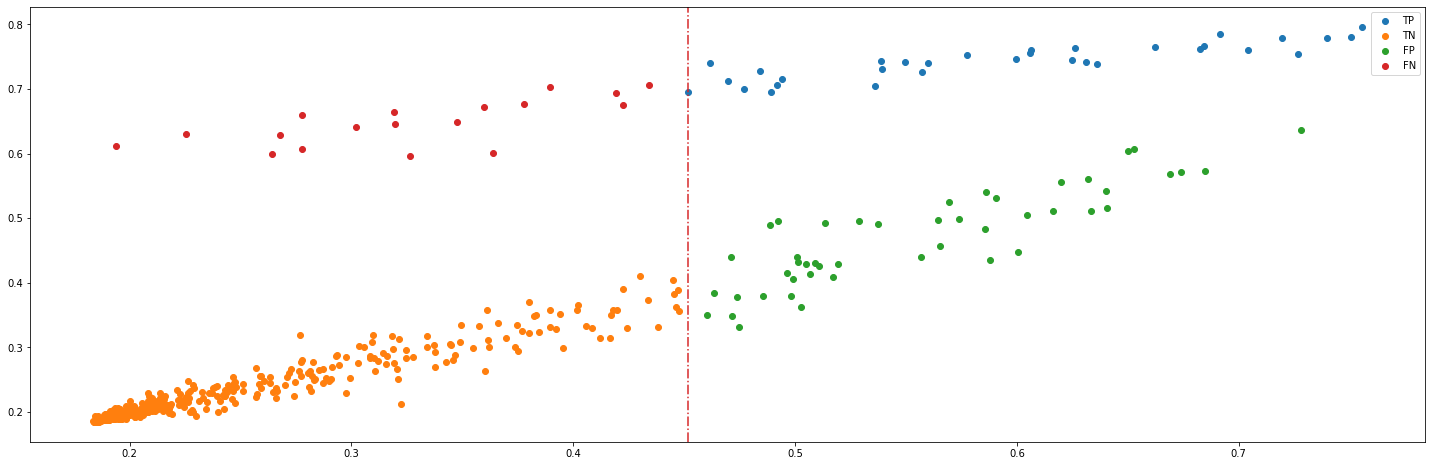

In [65]:
fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred_all'].to_numpy(), label=name)
plt.axvline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

In [424]:
pip install gower

Note: you may need to restart the kernel to use updated packages.


In [436]:
import gower

fi(25, 25)
plt.imshow(gower.gower_matrix(X))

In [438]:
cld = fcluster(Zd, 2, criterion='maxclust')
cld

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,